In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [25]:
import pandas as pd

def fix_gotoes_header(filepath):
    """
    Corrige les CSV Garmin exportés avec un header décalé (colonne 'GOTOES_CSV').
    → Décale tous les noms de colonnes d’un cran vers la gauche.
    """
    # Lecture brute du CSV
    df = pd.read_csv(filepath, header=0)
    
    # Vérifie si le premier header est 'GOTOES_CSV'
    if df.columns[0] == 'GOTOES_CSV':
        print(f"⚙️ Correction du header 'GOTOES_CSV' dans {filepath.split('\\')[-1]}")

        # Décale les noms de colonnes d’un cran vers la gauche
        new_cols = df.columns[1:].tolist() + ['extra_col']
        df.columns = new_cols
    
    return df


In [36]:
# Charger un seul fichier corrigé
marathon1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv")
marathon2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv")
semi1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_1.csv")
semi2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_2.csv")
semi3 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_3.csv")
dix1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_1.csv")
dix2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_2.csv")
# Vérifie le résultat
print("✅ Nouvelles colonnes :", marathon1.columns[:10].tolist())

⚙️ Correction du header 'GOTOES_CSV' dans marathon_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans marathon_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']


In [37]:
courses = {
    "Marathon 1": marathon1,
    "Marathon 2": marathon2,
    "Semi 1": semi1,
    "Semi 2": semi2,
    "Semi 3": semi3,
    "10 km 1": dix1,
    "10 km 2": dix2
}

In [ ]:
# Colonnes d'intérêt
cols = ['distance', 'timestamp', 'stance_time', 'vertical_oscillation', 'step_length', 'enhanced_speed', 'heart_rate', 'enhanced_altitude']



In [63]:
marathon1['enhanced_altitude'].value_counts()

enhanced_altitude
214.4    166
215.0    142
215.2    135
214.6    123
214.2    121
        ... 
294.4      1
289.4      1
290.0      1
288.2      1
288.6      1
Name: count, Length: 568, dtype: int64

In [75]:
# ======================================
# ⚙️ 1. Préparation et vérification des données
# ======================================
def prepare_course(df, course_name):
    """
    Nettoie et prépare les données Garmin avec les bonnes unités :
      - Supprime les lignes invalides
      - Convertit les colonnes en unités cohérentes
      - Filtre les valeurs aberrantes
    """
    # Colonnes attendues
    cols = ['distance', 'stance_time', 'vertical_oscillation', 'step_length',
            'enhanced_speed', 'heart_rate', 'enhanced_altitude']

    # Vérification de la présence des colonnes
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"❌ Colonnes manquantes dans {course_name}: {missing}")

    # Copie et sélection des colonnes
    df = df[cols].copy()

    # Suppression des lignes vides
    df = df.dropna()

    # ✅ Suppression des valeurs aberrantes sur le temps de contact au sol
    df = df[df['stance_time'] <= 1500]

    # ✅ Conversion des unités (corrigé selon tes précisions)
    # vertical_oscillation : divisé par 10 → passe en centimètres
    df['vertical_oscillation'] = df['vertical_oscillation'] / 10.0

    # step_length : divisé par 1000 → passe en mètres
    df['step_length'] = df['step_length'] / 1000.0

    # ✅ Suppression des vitesses nulles ou aberrantes
    df = df[df['enhanced_speed'] > 0]

    # Affichage optionnel pour suivi
    print(f"✅ {course_name} : {len(df)} lignes valides après nettoyage")

    return df


# Exemple de préparation sur une course
marathon1_clean = prepare_course(marathon1, "Marathon 1")


✅ Marathon 1 : 12131 lignes valides après nettoyage


In [76]:
def describe_biomechanics(df, course_name):
    stats = df[['enhanced_speed', 'heart_rate', 'stance_time',
                'vertical_oscillation', 'step_length']].describe().T.round(3)
    print(f"\n📊 Statistiques descriptives — {course_name}")
    print(stats)
    return stats

# Exemple
describe_biomechanics(marathon1_clean, "Marathon 1")



📊 Statistiques descriptives — Marathon 1
                        count     mean    std      min      25%      50%  \
enhanced_speed        12131.0   12.521  1.139    5.778   11.923   12.528   
heart_rate            12131.0  142.145  5.016   69.000  140.000  143.000   
stance_time           12131.0  240.030  9.931  202.000  235.000  239.000   
vertical_oscillation  12131.0    9.506  0.400    4.100    9.240    9.500   
step_length           12131.0    1.188  0.102    0.418    1.132    1.188   

                          75%      max  
enhanced_speed         13.201   17.600  
heart_rate            145.000  150.000  
stance_time           245.000  309.000  
vertical_oscillation    9.770   11.850  
step_length             1.248    1.746  


,count,mean,std,min,25%,50%,75%,max
enhanced_speed,12131.0,12.521,1.139,5.778,11.923,12.528,13.201,17.600
heart_rate,12131.0,142.145,5.016,69.000,140.000,143.000,145.000,150.000
stance_time,12131.0,240.030,9.931,202.000,235.000,239.000,245.000,309.000
vertical_oscillation,12131.0,9.506,0.400,4.100,9.240,9.500,9.770,11.850
step_length,12131.0,1.188,0.102,0.418,1.132,1.188,1.248,1.746


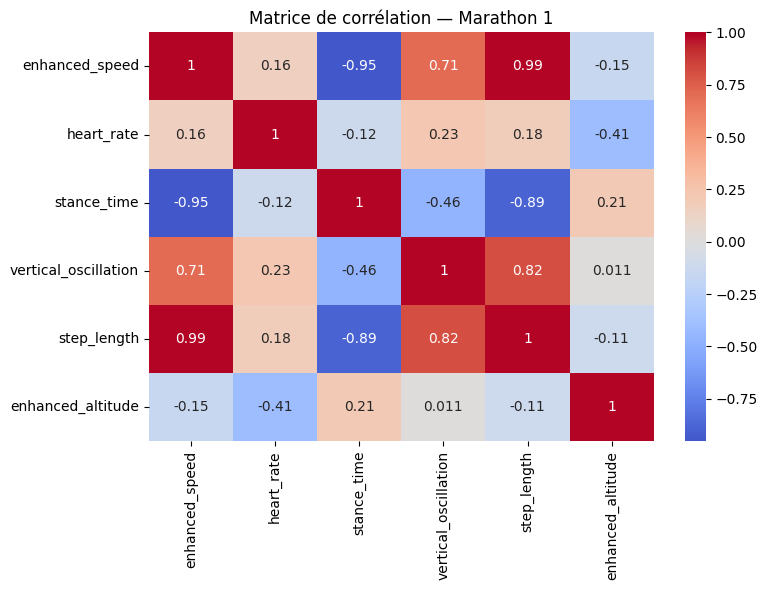


✅ Corrélations principales (Marathon 1):
  ➕ step_length ↔ speed : 0.985
  ➖ stance_time ↔ speed : -0.953
  ➖ altitude ↔ speed    : -0.148
  ➕ heart_rate ↔ altitude : -0.409


In [79]:
def plot_correlations(df, course_name):
    corr = df[['enhanced_speed', 'heart_rate', 'stance_time',
               'vertical_oscillation', 'step_length', 'enhanced_altitude']].corr()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Matrice de corrélation — {course_name}")
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Corrélations principales ({course_name}):")
    print(f"  ➕ step_length ↔ speed : {corr.loc['step_length','enhanced_speed']:.3f}")
    print(f"  ➖ stance_time ↔ speed : {corr.loc['stance_time','enhanced_speed']:.3f}")
    print(f"  ➖ altitude ↔ speed    : {corr.loc['enhanced_altitude','enhanced_speed']:.3f}")
    print(f"  ➕ heart_rate ↔ altitude : {corr.loc['heart_rate','enhanced_altitude']:.3f}")

# Exemple
plot_correlations(marathon1_clean, "Marathon 1")
